In [1]:
"""
\begin{figure}
    \centering
    \adjustimage{max size={0.5\linewidth}{0.6\paperheight}}{images/pareja_cn20-tgpm.png}
    \caption{Figura \ref{fig:cn20,tgpm} Ubicación espacial de las estaciones cn20,tgpm}
    \label{fig:cn20,tgpm}
\end{figure}

\begin{figure}
    \centering
    \adjustimage{max size={0.5\linewidth}{0.6\paperheight}}{images/pareja_unpm-tgmx.png}
    \caption{Figura \ref{fig:unpm,tgmx} Ubicación espacial de las estaciones unpm,tgmx}
    \label{fig:unpm,tgmx}
\end{figure}
"""

'\n\x08egin{figure}\n    \\centering\n    \x07djustimage{max size={0.5\\linewidth}{0.6\\paperheight}}{images/pareja_cn20-tgpm.png}\n    \\caption{Figura \ref{fig:cn20,tgpm} Ubicaci\xc3\xb3n espacial de las estaciones cn20,tgpm}\n    \\label{fig:cn20,tgpm}\n\\end{figure}\n\n\x08egin{figure}\n    \\centering\n    \x07djustimage{max size={0.5\\linewidth}{0.6\\paperheight}}{images/pareja_unpm-tgmx.png}\n    \\caption{Figura \ref{fig:unpm,tgmx} Ubicaci\xc3\xb3n espacial de las estaciones unpm,tgmx}\n    \\label{fig:unpm,tgmx}\n\\end{figure}\n'

In [1]:
import numpy as np
import gpstk
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%writefile ../code/Paper.py

import pandas as pd
def filter_by(df, constraints):
    """Filter MultiIndex by sublevels."""
    indexer = [constraints[name] if name in constraints else slice(None)
               for name in df.index.names]
    return df.loc[tuple(indexer)] if len(df.shape) == 1 else df.loc[tuple(indexer),]

pd.Series.filter_by = filter_by
pd.DataFrame.filter_by = filter_by

def Analisis(Archivo_Analisis, indices, columnas, scenario, num_sub_scenarios=3):

    def create_multi(df, index=['day'], cols=["mean_std_e", "d", "dr", "dc"]):
        multi=df.set_index(index, inplace=False).sort_index()
        return multi[cols]
    
    from IPython.display import display, clear_output, Javascript, Latex
    import pandas as pd
    backup = pd.HDFStore(Archivo_Analisis)

    df_res = backup['df_res']#.set_index("scenario")
    
    df13 = df_res.assign(Enviroment=df_res["scenario"].apply(lambda x: x.split(".")[0]))
    """
    df13 = create_multi(df_res,
                        index=['gps_day', 'stations', 'scenario'],
                        cols=["improve_by_agrupation", "improve_by_station"])
    """
    
    df13 = create_multi(df13, index=indices, cols=columnas)
    
    #display(df13.filter_by(filtro))
    filtro = set(["{0}.{1}".format(scenario, i) for i in range(1, num_sub_scenarios+1)])
    return backup, df13.filter_by(filtro)

def graficaScatter(df_in, agrupacion, scenario, profundidad=2):
    df_scatter = pd.DataFrame()
    df_scatter = df_scatter.assign(index=df_in["improve_by_agrupation"].apply(lambda x: x[0]))
    df_scatter = df_scatter.assign(index_station=df_in["improve_by_station"].apply(lambda improve_stations: [mean_std[0] for mean_std in improve_stations]))

    #display(df)
    num_sub_scenarios=3
    filtro = set(["{0}.{1}".format(scheme, i) for i in range(1,num_sub_scenarios+1) for scheme in scenario ])
    #print filtro
    df = df_scatter.filter_by({'stations': set(agrupacion)})

    df = df[df.index.get_level_values("scenario").isin(filtro)]
    #display(df)
    return df.mean(level=range(profundidad))

    #df[df.index.get_level_values('10').isin(['10', '11', '12'])]

    #print df.index.get_level_values("10").isin(df.index.names)
    #display(df.filter_by({'stations': {'cn20,tgpm'}}))
    
    
def get_stats(group):
    return {'min': group.min(), 'max': group.max(), 'count': group.count(), 'mean': group.mean()}

def get_ind_rov(group):
    return group["index_rovers"].mean()
    
    
def color_negative(value):
    success = value>0
    colors = success.apply(lambda x: "" if x else "color:red")
    return colors

def backgroundColor_negative(value, color):
    success = value>0
    colors = success.apply(lambda x: "" if x else 'background-color:%s'.format(color))
    return colors



Overwriting ../code/Paper.py


In [3]:
%run -i ../code/Paper.py

In [4]:
Archivo_Analisis = "./Resultados/Analisis_weight_010['8.1', '8.2', '8.3'].h5"
indices = ['stations', 'gps_day', 'Enviroment', 'scenario']
columnas = ["improve_by_agrupation", "improve_by_station"]
bk1, df1 = Analisis(Archivo_Analisis, indices, columnas, 1)


In [5]:
estaciones = ['tgmx,unpm', 'cn20,tgpm']#, 'ljrn,p553,p554,fzhs']
indices_groupby = ["stations", "gps_day","Enviroment"]

df = graficaScatter(df1, estaciones, range(5), profundidad=4)
df = df[df.index.get_level_values("gps_day").isin(["10"])]

label = "variacion_distancia"
caption = "Comportamiento constante del indice de mejora, ante la variacion en el observable de distancia."


strLatex2="""
            \\begin{table}[h!]
            \\begin{minipage}{\linewidth}
            \\begin{center}
            %s
            \\caption{Tabla \\ref{tab:%s} %s}
            \\label{tab:%s}
            \\end{center}
            \\end{minipage}
            \\end {table}
            """%(df.to_latex() , label, caption, label)

#display(Latex(latex(strLatex2, mode="inline")))

In [6]:
estaciones = ['cn20,tgpm', 'tgmx,unpm', 'ljrn,p553,p554,fzhs']
indices_groupby = ["stations", "gps_day","Enviroment","scenario"]


df = graficaScatter(df1, estaciones, range(8+1), profundidad=len(indices_groupby))
df2 = df.groupby(indices_groupby).sum().unstack("stations").unstack('gps_day')
#df2[(df2<-12)] = -12

In [8]:
backup = pd.HDFStore("./Resultados/Analisis_weight_010['2.1', '2.2', '2.3'].h5");
backup

<class 'pandas.io.pytables.HDFStore'>
File path: ./Resultados/Analisis_weight_010['2.1', '2.2', '2.3'].h5
/Resul_final            frame        (shape->[1,3]) 
/df_res                 frame        (shape->[72,8])

In [22]:
df_res = backup['Resul_final']["2.1"].to_dict()[0]
df_res.keys()

[10, 11, 12, 13]

In [38]:
df = df_res[10]["['cn200100.17', 'tgpm0100.17']"]
data_common = df.iloc[0]["data_common"]
type(data_common)

pandas.core.series.Series

hel


NameError: global name 'plot_in_doc' is not defined

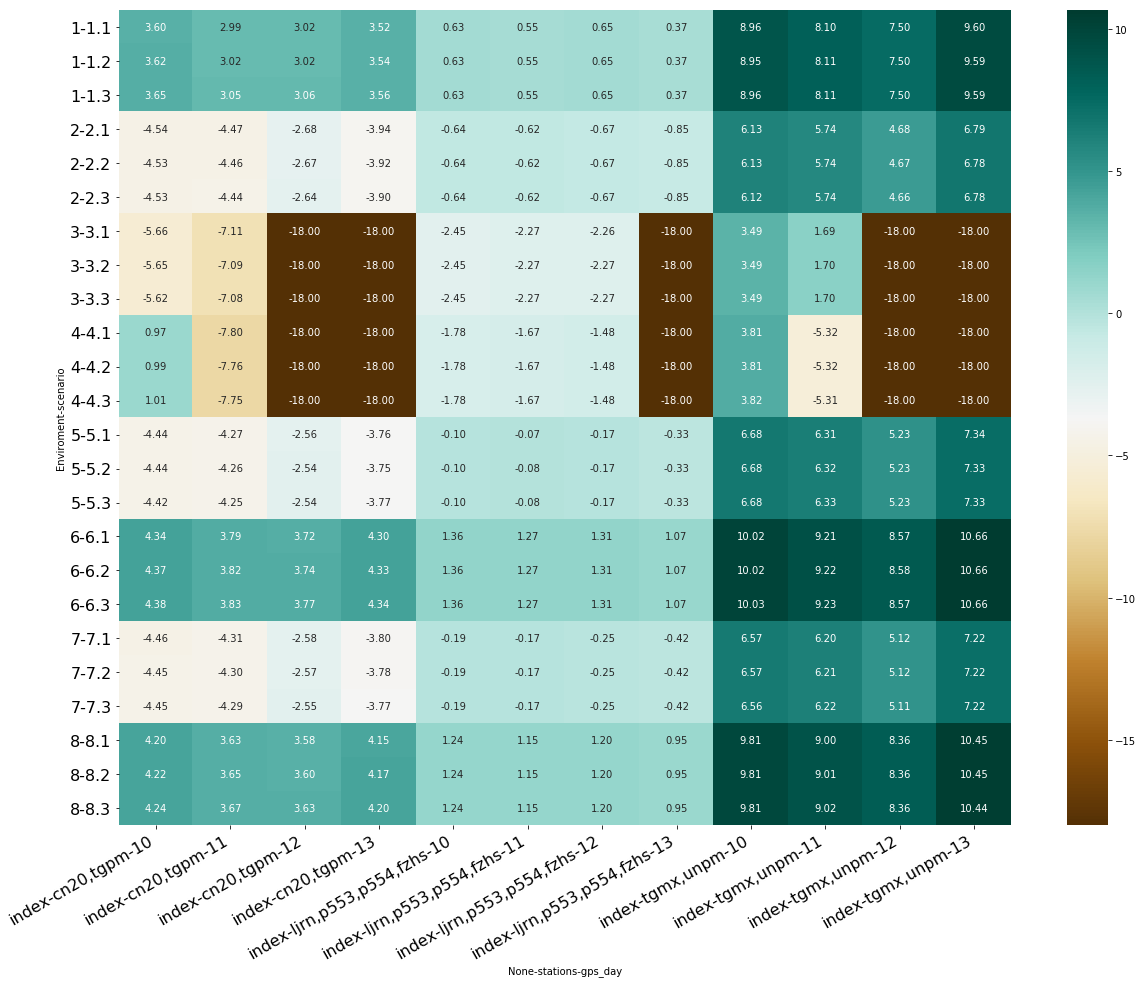

In [16]:
def plotHeat(data, filename="Resultados", title="Resultados de los experimentos", show_num=False):
    dat = data.copy()
    #dat[dat<dat.quantile(0.22)]=np.nanmin(dat.iloc[:,1].values)
    dat[(dat<-12)] = -18

    #dat = data.copy()
    #dat[dat<dat.quantile(0.15)]=np.nanmin(dat.iloc[:,1].values)

    print "hel"
    import seaborn as sns

    fig = plt.figure(figsize=(20,15))
    ax = fig.add_subplot(111)
    pal = sns.dark_palette("green", as_cmap=True)
    sns_plot = sns.heatmap(dat, annot=show_num, fmt=".2f", ax=ax, cmap="BrBG") # "BrBG" "RdYlGn"
    sns_plot.set_xticklabels(sns_plot.get_xticklabels(), rotation=30, fontsize = 16, ha="right")
    sns_plot.set_yticklabels(sns_plot.get_yticklabels(), rotation=0, fontsize = 16)
    sns.set(font_scale=1.8)
    ax = sns_plot.get_figure()

    fig.savefig(filename+".pdf", format='pdf', bbox_inches='tight')

    if plot_in_doc:
        display(Image(filename),Caption(filename+".pdf", filename, str(title)))
        
plotHeat(df2,"Resultados_totales", "Resultados de escenarios", True)

['stations', 'gps_day', 'Enviroment']
hel


NameError: global name 'plot_in_doc' is not defined

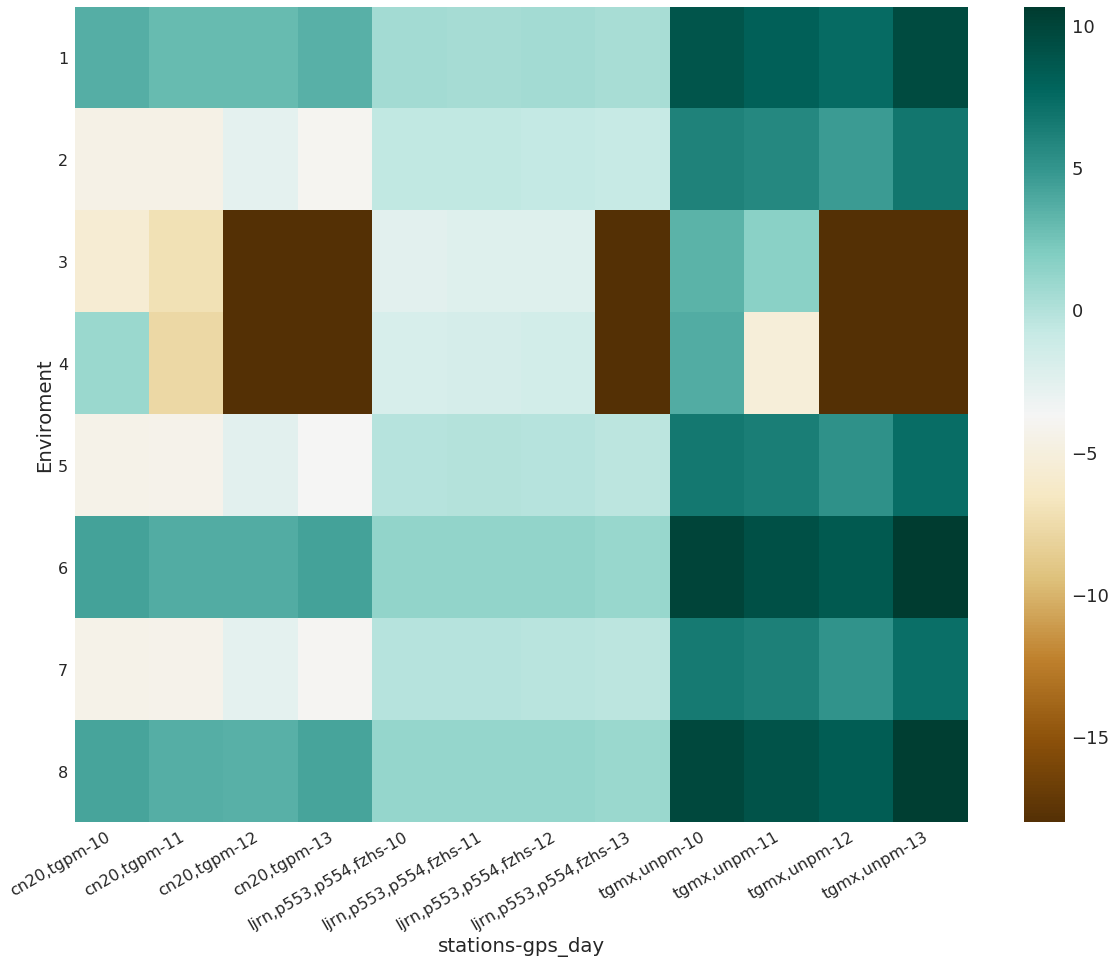

In [47]:
#display(df)
data = df.stack()
# saca el promedio de todos los subescenarios
print indices_groupby[:-1]
dataw = data.groupby(level=indices_groupby[:-1]).mean().unstack('stations').unstack('gps_day')
# Marcar estilo de los escenarios desfavorables

#data
plotHeat(dataw,"Resultados", "Index of improvement")

In [90]:
df2 = df1.assign(index_station=df1["improve_by_station"].apply(lambda improve_stations: [mean_std[0] for mean_std in improve_stations]))
df2 = df2.assign(index_rovers=df2["index_station"].apply(lambda index_station: index_station[1:]))

scenario=range(5)
num_sub_scenarios=3
indices_groupby = ["stations", "gps_day","Enviroment","scenario"]
filtro = set(["{0}.{1}".format(scheme, i) for i in range(1,num_sub_scenarios+1) for scheme in scenario ])
df2 = df2.filter_by({'stations': set(estaciones)})

#df2 = df2[df2.index.get_level_values("scenario").isin(filtro)]
df2.groupby(level=indices_groupby).apply(get_ind_rov)

TypeError: Could not convert [3.4039999999999999] to numeric

In [9]:
import seaborn as sns

In [105]:
df = graficaScatter(df1, estaciones, range(5), profundidad=4)
#df = df[df.index.get_level_values("gps_day").isin(["10"])]
#pd.pivot_table(df1, index=["Enviroment", "stations"], columns=["gps_day"], values=["index"])
df = df1.groupby(["stations","gps_day", "Enviroment", "scenario"])["improve_by_agrupation"].apply(lambda x: x[0][0]).unstack("stations").unstack('gps_day')
df = df[df.index.get_level_values("scenario").isin(["1.1","1.2","1.3","2.1","2.2","2.3"])]
#Latex(df.to_latex())
df

stations            cn20,tgpm                      ljrn,p553,p554,fzhs         \
gps_day                    10     11     12     13                  10     11   
Enviroment scenario                                                             
1          1.1          3.603  2.990  3.015  3.522               0.634  0.547   
           1.2          3.625  3.019  3.024  3.543               0.633  0.546   
           1.3          3.646  3.049  3.061  3.561               0.632  0.546   
2          2.1         -4.542 -4.466 -2.679 -3.936              -0.640 -0.618   
           2.2         -4.530 -4.459 -2.665 -3.920              -0.641 -0.618   
           2.3         -4.529 -4.443 -2.641 -3.903              -0.641 -0.620   

stations                          tgmx,unpm                       
gps_day                 12     13        10     11     12     13  
Enviroment scenario                                               
1          1.1       0.646  0.374     8.956  8.098  7.505  9.595  
           1.2       0.645  0.373     8.953  8.108  7.504  9.594  
           1.3       0.645  0.373     8.958  8.107  7.502  9.591  
2          2.1      -0.666 -0.850     6.132  5.736  4.677  6.785  
           2.2      -0.666 -0.851     6.129  5.738  4.672  6.780  
           2.3      -0.667 -0.852     6.123  5.744  4.662  6.778

In [103]:
escenarios = {"without correction": {"Enviroment":1, "principal": "none"             , "remotes:" :"none"},
              "Differential #1"   : {"Enviroment":2, "principal": "Dual Frequency"   , "remotes:" :"none"},
              "Differential #2"   : {"Enviroment":3, "principal": "Dual Frequency"   , "remotes:" :"klobuchar"},
              "Klobuchar"         : {"Enviroment":4, "principal": "klobuchar"        , "remotes:" :"klobuchar"},
              "Differential #3"   : {"Enviroment":5, "principal": "Standard shel"    , "remotes:" :"none"},
              "Standard shell"    : {"Enviroment":6, "principal": "Standard shel"    , "remotes:" :"Standard shel"},
              "Differential #4"   : {"Enviroment":7, "principal": "Thin Shell Model" , "remotes:" :"none"},
              "Thin Shell Model"  : {"Enviroment":8, "principal": "Thin Shell Model" , "remotes:" :"Thin Shell Model"}
}


vec = []
names = []
for s in ["without correction", "Differential #1"]:
    vec.append({"principal": "none","remotes:" :"none"})
    names.append(s)

#print escenarios.values()["Enviroment"].keys()
dfs = pd.DataFrame(escenarios, columns=escenarios.keys())
#dfs.sort_values(by="principal", ascending=False)
dfs

Thin Shell Model without correction Differential #3  \
Enviroment                 8                  1               5   
principal   Thin Shell Model               none   Standard shel   
remotes:    Thin Shell Model               none            none   

           Differential #2 Differential #1   Differential #4  Klobuchar  \
Enviroment               3               2                 7          4   
principal   Dual Frequency  Dual Frequency  Thin Shell Model  klobuchar   
remotes:         klobuchar            none              none  klobuchar   

           Standard shell  
Enviroment              6  
principal   Standard shel  
remotes:    Standard shel

In [101]:
import pandas as pd
import numpy as np
ion_mas= [None, "dual_frequency", "dual_frequency", "klobuchar",  "dual_frequency", "standard", "dual_frequency", "Thin Shell"]
ion_rov= [None,  None,            "klobuchar",      "klobuchar",  "standard",       "standard", "Thin Shell" ,    "Thin Shell"]
nam_env= ["without correction", "Differential #1", "Differential #2", "klobuchar", "Differential #3",
         "Standard shell", "Differential #4", "Thin Shell Model"]
#                 'principal':           ["receiver"]*8,
#                 'remote'   :           ["receiver"]*8,
exam_data  = {  'principal receiver'       : ion_mas, 
                'remotes  receivers'       : ion_rov,
                'index': range(1,9),
                'Enviroment' : nam_env
              
             }
labels = range(8)

df = pd.DataFrame(exam_data , index=labels).set_index("index")
df = df.groupby(by=["index", "Enviroment"], group_keys="index").sum()
df#Latex(df.to_latex())

principal receiver remotes  receivers
index Enviroment                                              
1     without correction                NaN                NaN
2     Differential #1        dual_frequency                NaN
3     Differential #2        dual_frequency          klobuchar
4     klobuchar                   klobuchar          klobuchar
5     Differential #3        dual_frequency           standard
6     Standard shell               standard           standard
7     Differential #4        dual_frequency         Thin Shell
8     Thin Shell Model           Thin Shell         Thin Shell

In [ ]:
#fig = plt.figure(figsize=(20,15))
#ax = fig.add_subplot(111)
dat = df.copy()
dat[df<df.quantile(0.15)]=np.nanmin(df.iloc[:,1].values)
sns.heatmap(dat, annot=True, fmt=".2f", ax=ax)

In [ ]:
display(data.style.apply(color_negative))

In [ ]:
def plotHeatMap(data):
    dat = data.copy()
    dat[dat<dat.quantile(0.15)]=np.nanmin(dat.iloc[:,1].values)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(111)
    #ax.pcolor(dat)
    
    print dat.columns.levels, dat.columns.names #xticks(np.arange(0, len(dat.columns),1), dat.columns)
    
    stations = dat.columns.levels[0]
    days = dat.columns.levels[1]
    
    xticks_minor = range(len(stations)*len(days))
    xticks = range(len(stations)/len(days))
    print 
    print xticks, xticks_minor, list(dat.columns.levels[1])

    
    ax.set_xticks(xticks)
    ax.set_xticks(xticks_minor, minor=True)
    ax.set_xticklabels(list(days)*len(stations))
    
    ax.grid("off", axis="x")
    ax.grid("off", axis="x", which="minor")
    ax.tick_params(axis="x", which="minor", direction="out", length=30)
    ax.tick_params(axis="x", which="major", bottom="off", top="off", pad=15)

    va = [0,-1, 0,-1, -1, -1]
    for t, y in zip(ax.get_xticklabels(), va):
        t.set_y(y)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size="5%", pad=0.05)
    im=ax.imshow(dat, extent=(0., len(dat.columns), 0, len(dat.index)))
    fig.colorbar(im, cax=cax, orientation='vertical')

#plotHeatMap(data)  

sns.set(font_scale=1.8)

In [ ]:
dft

In [ ]:
dat = data.copy()
dat[dat<dat.quantile(0.15)]=np.nanmin(dat.iloc[:,1].values)


#dat = data.copy()
#dat[dat<dat.quantile(0.15)]=np.nanmin(dat.iloc[:,1].values)

import seaborn as sns

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
sns_plot = sns.heatmap(dat, annot=True, ax=ax, cmap="RdYlGn") # "RdYlGn"
ax = sns_plot.get_figure()

fig.savefig("Resultados.pdf", format='pdf', bbox_inches='tight')

if plot_in_doc:
    display(Image("Resultados"),Caption("Resultados.pdf", "Resultados", str("Resultados de los experimentos")))

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import groupby

def test_table():
    data_table = pd.DataFrame({'Room':['Room A']*4 + ['Room B']*4,
                               'Shelf':(['Shelf 1']*2 + ['Shelf 2']*2)*2,
                               'Staple':['Milk','Water','Sugar','Honey','Wheat','Corn','Chicken','Cow'],
                               'Quantity':[10,20,5,6,4,7,2,1],
                               'Ordered':np.random.randint(0,10,8)
                               })
    return data_table

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

df = test_table().groupby(['Room','Shelf','Staple']).sum()
fig = plt.figure()
ax = fig.add_subplot(111)
df.plot(kind='bar',stacked=True, ax=fig.gca())
#Below 3 lines remove default labels
# labels = ['' for item in ax.get_xticklabels()]
# ax.set_xticklabels(labels)
# ax.set_xlabel('')
# label_group_bar_table(ax, df)
# fig.subplots_adjust(bottom=.1*df.index.nlevels)
plt.show()